# Emojispace: Visualizing twitter messages based on emojis

## By: Eric S. Tellez

This example creates a vector space model for classify emojis in Twitter messages, then process and create vectors from messages and project them using a UMAP model. The projection uses the SimilaritySearch `allknn` operation.

Note: this notebook must be run with Jupyter and the environment variable JULIA_NUM_THREADS=auto

_june 1st, 2023: working with `SimilaritySearch` v0.10 and `TextSearch` v0.16. I also changed from `Plots` to `Makie` and now using `SpectralLayout` instead of random layout for embedding initialization._

In [1]:
using Pkg
Pkg.activate(".")

Pkg.add([
    PackageSpec(name="SimilaritySearch", version="0.10"),
    PackageSpec(name="SimSearchManifoldLearning", version="0.2"),
    PackageSpec(name="TextSearch", version="0.16"),
    PackageSpec(name="CodecZlib"),
    PackageSpec(name="CategoricalArrays"),
    PackageSpec(name="JSON"),
    PackageSpec(name="JLD2"),
    PackageSpec(name="CairoMakie"),
    PackageSpec(name="ColorSchemes"),
    PackageSpec(name="Colors"),
])


  Activating project at `~/Research/SimilaritySearchDemos/emojispace`
   Resolving package versions...
  No Changes to `~/Research/SimilaritySearchDemos/emojispace/Project.toml`
  No Changes to `~/Research/SimilaritySearchDemos/emojispace/Manifest.toml`


In [2]:
using SimilaritySearch, SimSearchManifoldLearning, TextSearch
using CategoricalArrays, CodecZlib, JSON, LinearAlgebra
using CairoMakie, ColorSchemes, Colors
using Downloads: download


# Functions to parse and vectorize texts

In [3]:
function parse_corpus(corpusfile)
    labels = String[]
	corpus = String[]
    
	open(corpusfile) do f
		for line in eachline(GzipDecompressorStream(f))
			r = JSON.parse(line)
			push!(labels, r["klass"])
			push!(corpus, r["text"])    
		end
	end
    
    corpus, categorical(labels)
end

function text_model_and_vectors(corpus, labels)
    textconfig = TextConfig(group_usr=true, group_url=true, del_diac=true, lc=true, group_num=true, nlist=[1], qlist=[])
    voc = Vocabulary(textconfig, corpus) # corpus here can be a sample to avoid double parsing
    model = VectorModel(EntropyWeighting(), TfWeighting(), voc, corpus, labels; mindocs=3, smooth=1.0)
	#model = VectorModel(IdfWeighting(), TfWeighting(), textconfig, corpus; mindocs=3)
    
	vectors = vectorize_corpus(model, corpus)
    
    (; textconfig, model, vectors, labels)
end

function create_dataset(corpusfile)
    corpus, labels = parse_corpus(corpusfile)
    text_model_and_vectors(corpus, labels)
end

create_dataset (generic function with 1 method)

# Downloading the dataset, parsing and vectorizing functions

In [4]:
dbfile = "emo50k.json.gz"
baseurl = "https://github.com/sadit/TextClassificationTutorial/blob/main/data"

!isfile(dbfile) && download("$baseurl/$dbfile?raw=true", dbfile)
D = create_dataset(dbfile)
@info "this can take a while depending on the number of threads and the speed of your system"

[ Info: this can take a while depending on the number of threads and the speed of your system


# Functions to create low dimensional projections

In [5]:
function umap_embeddings(index, db; k=20, n_epochs=100, neg_sample_rate=5, tol=1e-3, layout=SpectralLayout())
    #layout = RandomLayout()
    # increase both `n_epochs` and `neg_sample_rate` to improve projection
    #layout = SpectralLayout() ## the results are much better with Spectral layout
    @time U2 = fit(UMAP, index; k, neg_sample_rate, layout, n_epochs, tol) 
    @time U3 = fit(U2, 3; neg_sample_rate, n_epochs, tol)  # reuses U2
    #jldsave(umapfile, e2=U2.embedding, e3=U3.embedding)
    @time e2 = clamp.(predict(U2, db), -10f0, 10f0)
    @time e3 = clamp.(predict(U3, db), -10f0, 10f0)
    (; e2, e3)
end

function normcolors(V)
    min_, max_ = extrema(V)
    V .= (V .- min_) ./ (max_ - min_)
    V .= clamp.(V, 0, 1)
end



normcolors (generic function with 1 method)

# Visualizations

UMAP projection can take a while, even on multithreading systems. Note that we are creating 2d and 3d projections

In [6]:
# spectral layout is too slow for the input-data, so the db is sampled to create the umap model.
# if you need a model with all data points, then use RandomLayout() 
layout =  SpectralLayout()
dist = NormalizedCosineDistance()
index = ExhaustiveSearch(; db=rand(D.vectors, 2000), dist)
length(index)

e2, e3 = umap_embeddings(index, D.vectors; layout);

  0.125599 seconds (129.55 k allocations: 8.596 MiB, 754.62% compilation time)


*** computing graph
*** layout embedding SpectralLayout
*** fit ab / embedding


  2.743704 seconds (2.36 M allocations: 217.627 MiB, 3.68% gc time, 119.43% compilation time)


*** opt embedding
UMAP construction time cost report:
- fuzzy graph: 0.131956375
- embedding init: 2.00512235
- embedding opt: 0.096448601



  0.094561 seconds (72 allocations: 64.125 KiB)
  3.587810 seconds (305.31 k allocations: 47.454 MiB, 9.69% compilation time)
  3.557203 seconds (275 allocations: 28.064 MiB)


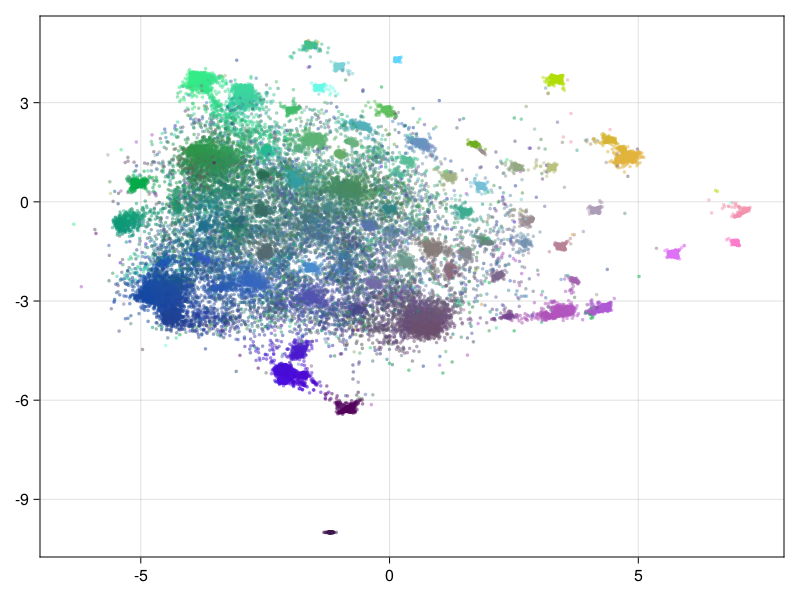

In [7]:
function plot_umap(e2, e3)
    normcolors(@view e3[1, :])
    normcolors(@view e3[2, :])
    normcolors(@view e3[3, :])

    C = [RGBAf(c[1], c[2], c[3], 0.5) for c in eachcol(e3)]
    X = @view e2[1, :]
    Y = @view e2[2, :]
    scatter(X, Y, color=C, markersize=5)
end

#=f = Figure(resolution = (800, 800))
ax = Axis(f[1,1], title = "Emoji's visualization", aspect = DataAspect())
hexbin!(ax, (@view e2[1, :]), (@view e2[2, :]); bins=200)
plot_umap(ax, e2, e3)
f
=#

plot_umap(e2, e3)

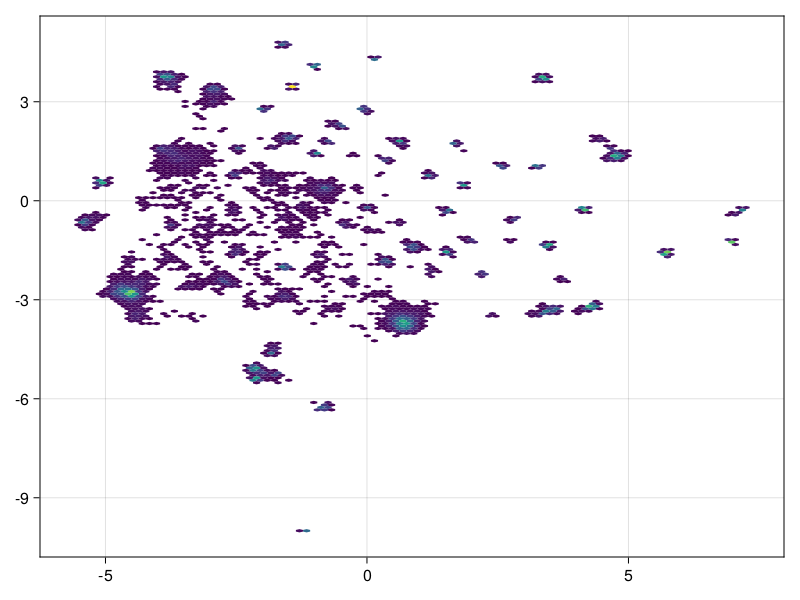

In [8]:
hexbin((@view e2[1, :]), (@view e2[2, :]); bins=200, threshold=7)

# Final notes
The final projections show that while spatial distance is quite preserved (3d and 2d), the colors based on labels are more or less mixed in many of the visible clusters. This is an indicator that other models may provide better results while using distance based classifiers. However, improving this models are beyond the scope of this example notebook.

Parsing and analyzing text is made with `TextSearch` and low dimensional projections with `SimSearchManifoldLearning`. `SimilaritySearch` is used for computing the all $k$ nearest neighbors needed by the UMAP model. Note that this notebook should be ran with several threads to reduce time costs.

The precise packages used in this example are listed below

In [9]:
Pkg.status()

Status `~/Research/SimilaritySearchDemos/emojispace/Project.toml`
  [13f3f980] CairoMakie v0.10.5
  [324d7699] CategoricalArrays v0.10.8
  [944b1d66] CodecZlib v0.7.1
  [35d6a980] ColorSchemes v3.21.0
  [5ae59095] Colors v0.12.10
  [033835bb] JLD2 v0.4.31
  [682c06a0] JSON v0.21.4
  [ca7ab67e] SimSearchManifoldLearning v0.2.8
  [053f045d] SimilaritySearch v0.10.8
  [7f6f6c8a] TextSearch v0.16.2
